In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Travel.csv")
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [3]:
df.isnull().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [4]:
df['Gender'].value_counts()

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [5]:
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')

In [6]:
df['MaritalStatus'].value_counts()

MaritalStatus
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: count, dtype: int64

In [7]:
df['MaritalStatus'] = df['MaritalStatus'].replace('Single', 'Unmarried')

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(['ProdTaken', 'CustomerID'], axis = 1)
y = df[['ProdTaken']]

In [10]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify= y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3910, 18), (978, 18), (3910, 1), (978, 1))

In [11]:
X_train.columns

Index(['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation',
       'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome'],
      dtype='object')

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

In [20]:
from sklearn.model_selection import GridSearchCV

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [14]:
from xgboost import XGBClassifier

In [15]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder())
])


preprocessor = ColumnTransformer([
    ('numeric',numerical_pipeline, num_features),
    ('categoric', categorical_pipeline, cat_features)
])

pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('xgb', XGBClassifier())
])

In [22]:
params = {
    "xgb__n_estimators":  [200, 400],
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.03, 0.05, 0.1],
    "xgb__subsample":[.8, 1.0],
    "xgb__colsample_bytree":[.8, 1.0],
    'xgb__min_child_weigth': [1, 5, 10],
    'xgb__gamma': [0, .5, 1.0],
    'xgb__reg_lambda': [1, 5, 10]
}

model_xgb = GridSearchCV(pipeline, params, cv= 3, n_jobs= -1, verbose= 1, scoring='f1')
model_xgb.fit(X_train, y_train)

print(model_xgb.best_params_)
print(model_xgb.score(X_train, y_train), model_xgb.best_score_, model_xgb.score(X_test, y_test))

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
{'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__min_child_weigth': 1, 'xgb__n_estimators': 400, 'xgb__reg_lambda': 1, 'xgb__subsample': 1.0}
1.0 0.7509009991531469 0.8132530120481928


In [23]:
y_pred = model_xgb.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       794
           1       0.91      0.73      0.81       184

    accuracy                           0.94       978
   macro avg       0.93      0.86      0.89       978
weighted avg       0.94      0.94      0.93       978



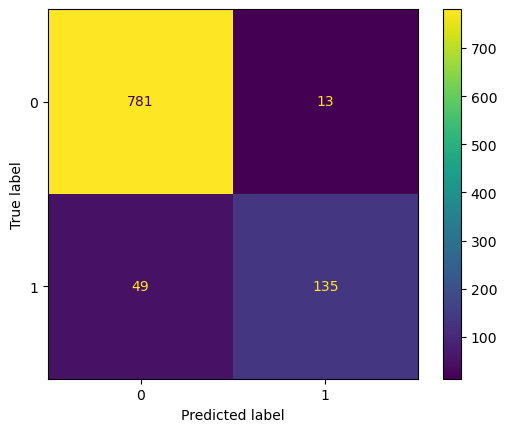

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Save Model

In [40]:
import pickle

with open("prodtaken.pkl", 'wb') as f:
    pickle.dump(model_xgb.best_estimator_, f)

# Load

In [42]:
with open('prodtaken.pkl', 'rb') as f:
    load_model = pickle.load(f)

In [30]:
X_train.columns

Index(['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation',
       'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome'],
      dtype='object')

In [38]:
# pastikan urutan kolom sama persis (penting!)
sample = sample[X_train.columns]

In [36]:
df['NumberOfChildrenVisiting'].value_counts()

NumberOfChildrenVisiting
1.0    2080
2.0    1335
0.0    1082
3.0     325
Name: count, dtype: int64

In [43]:
sample = pd.DataFrame([{
    'Age': 33,
    'TypeofContact':"Company Invited",  
    'CityTier': 3,
    'DurationOfPitch': 17.0,
    'Occupation':"Small Business",  
    'Gender': 'Male',
    'NumberOfPersonVisiting': 4.0,      # dari TotalVisiting
    'NumberOfFollowups': 3.0,
    'ProductPitched': 'Deluxe',
    'PreferredPropertyStar': 5.0,
    'MaritalStatus': 'Unmarried',
    'NumberOfTrips': 6.0,
    'Passport': 0,
    'PitchSatisfactionScore': 5,
    'OwnCar': 1,
    'NumberOfChildrenVisiting': 0.0,       # asumsi
    'Designation': 'Senior Manager',
    'MonthlyIncome': 17342.0
}])



In [39]:
prodtaken = model_xgb.predict(sample)[0]
print("predict Prodtaken:",  prodtaken)

predict Prodtaken: 1
